<a href="https://colab.research.google.com/github/jozeni00/csci166_deep_q_learning/blob/main/Frogger_DQN_Complete_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CSCI 166 Final Project - Frogger DQN Study
**Game**: ALE/Frogger-v5  
**Experiments**: 5 total (Baseline DQN + 4 DDQN variants)  
[View Experiment Files](https://drive.google.com/drive/folders/1vZ-L1Fx_MoDAPd_FHETGo3iAtkwlIPKA?usp=sharing)
---

## Install Dependencies

In [ ]:
!pip install -q gymnasium[atari,accept-rom-license]
!pip install -q stable-baselines3
!pip install -q moviepy imageio[ffmpeg]
print("✓ Dependencies installed")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 187.2/187.2 kB 16.9 MB/s eta 0:00:00
✓ Dependencies installed


In [ ]:
# Accept ROM license
!AutoROM --accept-license --quiet
print("✓ Atari ROMs installed")

/bin/bash: line 1: AutoROM: command not found
✓ Atari ROMs installed


## Mount Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
print("✓ Google Drive mounted")

Mounted at /content/drive
✓ Google Drive mounted


## Libraries

In [ ]:
import os
import json
import shutil
import time
from datetime import datetime
from dataclasses import dataclass
from pathlib import Path
import collections
import typing as tt

import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim

import ale_py  # Register Atari environments
import gymnasium as gym
from gymnasium import spaces
from gymnasium.wrappers import RecordVideo
from stable_baselines3.common import atari_wrappers
from IPython.display import Video, display

print(f"✓ Libraries imported")
print(f"  PyTorch: {torch.__version__}")
print(f"  Device: {'GPU' if torch.cuda.is_available() else 'CPU'}")
if torch.cuda.is_available():
    print(f"  GPU: {torch.cuda.get_device_name(0)}")

✓ Libraries imported
  PyTorch: 2.9.0+cu126
  Device: GPU
  GPU: NVIDIA A100-SXM4-40GB


Gym has been unmaintained since 2022 and does not support NumPy 2.0 amongst other critical functionality.
Please upgrade to Gymnasium, the maintained drop-in replacement of Gym, or contact the authors of your software and request that they upgrade.
See the migration guide at https://gymnasium.farama.org/introduction/migration_guide/ for additional information.
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


## Our Config

1. **Baseline → DDQN**: Algorithm change
2. **Learning Rate**: 1e-4 → 5e-5
3. **Epsilon Decay**: 150k → 300k frames
4. **Target Sync**: 1000 → 2500 frames
5. **Replay Buffer**: 10k → 30k capacity

In [ ]:
# Experiment definitions
EXPERIMENTS = {
    'baseline_dqn': {
        'name': 'Baseline DQN',
        'use_ddqn': False,
        'lr': 1e-4,
        'eps_decay_frames': 150000,
        'target_sync_frames': 1000,
        'replay_size': 10000,
        'batch_size': 32,
        'total_steps': 500000,
        'changes': []
    },
    'ddqn': {
        'name': 'Double DQN',
        'use_ddqn': True,
        'lr': 1e-4,
        'eps_decay_frames': 150000,
        'target_sync_frames': 1000,
        'replay_size': 10000,
        'batch_size': 32,
        'total_steps': 500000,
        'changes': ['Algorithm: DQN → Double DQN']
    },
    'ddqn_lr': {
        'name': 'DDQN + Lower LR',
        'use_ddqn': True,
        'lr': 5e-5,
        'eps_decay_frames': 150000,
        'target_sync_frames': 1000,
        'replay_size': 10000,
        'batch_size': 32,
        'total_steps': 500000,
        'changes': ['Algorithm: DQN → Double DQN', 'Learning Rate: 1e-4 → 5e-5']
    },
    'ddqn_eps': {
        'name': 'DDQN + Longer Exploration',
        'use_ddqn': True,
        'lr': 1e-4,
        'eps_decay_frames': 300000,
        'target_sync_frames': 1000,
        'replay_size': 10000,
        'batch_size': 32,
        'total_steps': 500000,
        'changes': ['Algorithm: DQN → Double DQN', 'Epsilon Decay: 150k → 300k frames']
    },
    'ddqn_target': {
        'name': 'DDQN + Slower Target Sync',
        'use_ddqn': True,
        'lr': 1e-4,
        'eps_decay_frames': 150000,
        'target_sync_frames': 2500,
        'replay_size': 10000,
        'batch_size': 32,
        'total_steps': 500000,
        'changes': ['Algorithm: DQN → Double DQN', 'Target Sync: 1000 → 2500 frames']
    },
    'ddqn_replay': {
        'name': 'DDQN + Bigger Replay',
        'use_ddqn': True,
        'lr': 1e-4,
        'eps_decay_frames': 150000,
        'target_sync_frames': 1000,
        'replay_size': 30000,
        'batch_size': 32,
        'total_steps': 500000,
        'changes': ['Algorithm: DQN → Double DQN', 'Replay Buffer: 10k → 30k']
    }
}

# Constants
ENV_NAME = "ALE/Frogger-v5"
GAMMA = 0.99
EPSILON_START = 1.0
EPSILON_FINAL = 0.01
REPLAY_START_SIZE = 10000
FRAME_STACK = 4

# Paths
BASE_DIR = "/content/drive/MyDrive/CSCI166_Frogger_Project"
RESULTS_DIR = f"{BASE_DIR}/results"
MODELS_DIR = f"{BASE_DIR}/models"
VIDEOS_DIR = f"{BASE_DIR}/videos"
PLOTS_DIR = f"{BASE_DIR}/plots"

# Create directories
for d in [RESULTS_DIR, MODELS_DIR, VIDEOS_DIR, PLOTS_DIR]:
    os.makedirs(d, exist_ok=True)

print(f"✓ Configuration loaded")
print(f"  Environment: {ENV_NAME}")
print(f"  Experiments: {len(EXPERIMENTS)}")
print(f"  Save location: {BASE_DIR}")

✓ Configuration loaded
  Environment: ALE/Frogger-v5
  Experiments: 6
  Save location: /content/drive/MyDrive/CSCI166_Frogger_Project


## DQN Model

In [ ]:
class DQN(nn.Module):
    """Deep Q-Network with convolutional layers for Atari frames"""
    def __init__(self, input_shape, n_actions):
        super(DQN, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(input_shape[0], 32, kernel_size=8, stride=4),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, stride=1),
            nn.ReLU(),
            nn.Flatten(),
        )
        conv_out_size = self.conv(torch.zeros(1, *input_shape)).size()[-1]
        self.fc = nn.Sequential(
            nn.Linear(conv_out_size, 512),
            nn.ReLU(),
            nn.Linear(512, n_actions)
        )

    def forward(self, x):
        x = x.float() / 255.0
        return self.fc(self.conv(x))

print("✓ DQN model defined")

✓ DQN model defined


In [ ]:
class ImageToPyTorch(gym.ObservationWrapper):
    """Convert image from HWC to CHW format for PyTorch"""
    def __init__(self, env):
        super().__init__(env)
        obs = self.observation_space
        assert isinstance(obs, gym.spaces.Box) and len(obs.shape) == 3
        new_shape = (obs.shape[-1], obs.shape[0], obs.shape[1])
        self.observation_space = gym.spaces.Box(
            low=obs.low.min(), high=obs.high.max(),
            shape=new_shape, dtype=obs.dtype
        )

    def observation(self, observation):
        return np.moveaxis(observation, 2, 0)


class BufferWrapper(gym.ObservationWrapper):
    """Stack last N frames for temporal context"""
    def __init__(self, env, n_steps):
        super().__init__(env)
        obs = env.observation_space
        assert isinstance(obs, spaces.Box)
        new_obs = gym.spaces.Box(
            obs.low.repeat(n_steps, axis=0),
            obs.high.repeat(n_steps, axis=0),
            dtype=obs.dtype
        )
        self.observation_space = new_obs
        self.buffer = collections.deque(maxlen=n_steps)

    def reset(self, **kwargs):
        for _ in range(self.buffer.maxlen):
            self.buffer.append(np.zeros_like(self.env.observation_space.low))
        obs, info = self.env.reset(**kwargs)
        return self.observation(obs), info

    def observation(self, observation):
        self.buffer.append(observation)
        return np.concatenate(list(self.buffer))


def make_env(env_name, render_mode=None):
    """Create and wrap Atari environment"""
    env = gym.make(env_name, render_mode=render_mode)
    env = atari_wrappers.AtariWrapper(env, clip_reward=False, noop_max=0)
    env = ImageToPyTorch(env)
    env = BufferWrapper(env, n_steps=FRAME_STACK)
    return env

print("✓ Environment wrappers defined")

✓ Environment wrappers defined


## Experience Replay / Agent

In [ ]:
@dataclass
class Experience:
    state: np.ndarray
    action: int
    reward: float
    done: bool
    new_state: np.ndarray


class ExperienceBuffer:
    def __init__(self, capacity):
        self.buffer = collections.deque(maxlen=capacity)

    def __len__(self):
        return len(self.buffer)

    def append(self, exp):
        self.buffer.append(exp)

    def sample(self, batch_size):
        indices = np.random.choice(len(self), batch_size, replace=False)
        return [self.buffer[i] for i in indices]


class Agent:
    def __init__(self, env, buffer):
        self.env = env
        self.buffer = buffer
        self.state = None
        self.total_reward = 0.0
        self._reset()

    def _reset(self):
        self.state, _ = self.env.reset()
        self.total_reward = 0.0

    @torch.no_grad()
    def play_step(self, net, device, epsilon=0.0):
        if np.random.random() < epsilon:
            action = self.env.action_space.sample()
        else:
            state_v = torch.as_tensor(self.state).unsqueeze(0).to(device)
            q_vals = net(state_v)
            action = int(q_vals.argmax(dim=1).item())

        new_state, reward, terminated, truncated, _ = self.env.step(action)
        done = terminated or truncated
        self.total_reward += reward

        self.buffer.append(Experience(
            state=self.state,
            action=action,
            reward=float(reward),
            done=done,
            new_state=new_state
        ))

        self.state = new_state
        if done:
            ep_reward = self.total_reward
            self._reset()
            return ep_reward
        return None

print("✓ Experience replay and agent defined")

✓ Experience replay and agent defined


## Loss Functions

In [ ]:
def batch_to_tensors(batch, device):
    states = torch.as_tensor(np.array([e.state for e in batch])).to(device)
    actions = torch.LongTensor([e.action for e in batch]).to(device)
    rewards = torch.FloatTensor([e.reward for e in batch]).to(device)
    dones = torch.BoolTensor([e.done for e in batch]).to(device)
    new_states = torch.as_tensor(np.array([e.new_state for e in batch])).to(device)
    return states, actions, rewards, dones, new_states


def calc_loss(batch, net, tgt_net, device, use_ddqn=False):
    """Calculate TD loss with optional Double DQN"""
    states, actions, rewards, dones, new_states = batch_to_tensors(batch, device)

    # Current Q values
    q_values = net(states).gather(1, actions.unsqueeze(-1)).squeeze(-1)

    # Next Q values
    with torch.no_grad():
        if use_ddqn:
            # Double DQN: select action with online net, evaluate with target net
            next_actions = net(new_states).argmax(dim=1)
            next_q = tgt_net(new_states).gather(1, next_actions.unsqueeze(-1)).squeeze(-1)
        else:
            # Standard DQN: max Q from target network
            next_q = tgt_net(new_states).max(dim=1)[0]

        next_q[dones] = 0.0
        target = rewards + GAMMA * next_q

    return nn.MSELoss()(q_values, target)

print("✓ Loss functions defined")

✓ Loss functions defined


## Video Recording

In [ ]:
def record_video(net, device, exp_name, stage, num_episodes=2):
    """
    Record video of agent playing

    Args:
        net: Trained DQN model
        device: torch device
        exp_name: Experiment name for file organization
        stage: 'early' or 'late'
        num_episodes: Number of episodes to record
    """
    video_dir = f"{VIDEOS_DIR}/{exp_name}"
    os.makedirs(video_dir, exist_ok=True)

    # Create temp directory for recording
    temp_dir = f"/content/videos_temp_{exp_name}_{stage}"
    os.makedirs(temp_dir, exist_ok=True)

    # Create environment with video recording
    env = make_env(ENV_NAME, render_mode="rgb_array")
    env = RecordVideo(
        env,
        video_folder=temp_dir,
        name_prefix=f"{exp_name}_{stage}",
        episode_trigger=lambda ep: True
    )

    net.eval()
    rewards = []

    for ep in range(num_episodes):
        state, _ = env.reset()
        total_reward = 0
        done = False

        while not done:
            with torch.no_grad():
                state_v = torch.as_tensor(state).unsqueeze(0).to(device)
                action = int(net(state_v).argmax(dim=1).item())

            state, reward, terminated, truncated, _ = env.step(action)
            total_reward += reward
            done = terminated or truncated

        rewards.append(total_reward)

    env.close()

    # Copy videos to permanent location
    for file in os.listdir(temp_dir):
        if file.endswith('.mp4'):
            src = os.path.join(temp_dir, file)
            dst = os.path.join(video_dir, file)
            shutil.copy(src, dst)

    # Cleanup temp directory
    shutil.rmtree(temp_dir, ignore_errors=True)

    print(f"  ✓ Recorded {num_episodes} videos ({stage}), avg reward: {np.mean(rewards):.1f}")
    return np.mean(rewards)

print("✓ Video recording function defined")

✓ Video recording function defined


## Training

In [ ]:
def train_experiment(exp_name, config):
    """
    Train a single experiment and save all results
    """
    print(f"\n{'='*70}")
    print(f"Starting: {config['name']}")
    print(f"Changes: {', '.join(config['changes']) if config['changes'] else 'None (baseline)'}")
    print(f"{'='*70}\n")

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Create experiment directories
    exp_results_dir = f"{RESULTS_DIR}/{exp_name}"
    exp_models_dir = f"{MODELS_DIR}/{exp_name}"
    os.makedirs(exp_results_dir, exist_ok=True)
    os.makedirs(exp_models_dir, exist_ok=True)

    # Save config
    with open(f"{exp_results_dir}/config.json", 'w') as f:
        json.dump(config, f, indent=2)

    # Create environment and networks
    env = make_env(ENV_NAME)
    net = DQN(env.observation_space.shape, env.action_space.n).to(device)
    tgt_net = DQN(env.observation_space.shape, env.action_space.n).to(device)
    tgt_net.load_state_dict(net.state_dict())

    # Setup training
    buffer = ExperienceBuffer(config['replay_size'])
    agent = Agent(env, buffer)
    optimizer = optim.Adam(net.parameters(), lr=config['lr'])

    # Tracking
    metrics = {
        'steps': [],
        'episodes': [],
        'episode_rewards': [],
        'mean_reward_100': [],
        'epsilon': [],
        'loss': []
    }

    episode_rewards = []
    frame_idx = 0
    start_time = time.time()
    early_video_recorded = False

    # Training loop
    while frame_idx < config['total_steps']:
        frame_idx += 1

        # Epsilon decay
        epsilon = max(
            EPSILON_FINAL,
            EPSILON_START - (frame_idx / config['eps_decay_frames']) * (EPSILON_START - EPSILON_FINAL)
        )

        # Play step
        reward = agent.play_step(net, device, epsilon)

        if reward is not None:
            episode_rewards.append(reward)
            mean_reward = np.mean(episode_rewards[-100:])

            # Log metrics
            metrics['steps'].append(frame_idx)
            metrics['episodes'].append(len(episode_rewards))
            metrics['episode_rewards'].append(reward)
            metrics['mean_reward_100'].append(mean_reward)
            metrics['epsilon'].append(epsilon)

            # Print progress every 10 episodes
            if len(episode_rewards) % 10 == 0:
                elapsed = time.time() - start_time
                print(f"  Step {frame_idx:6d} | Ep {len(episode_rewards):4d} | "
                      f"Reward: {reward:6.1f} | Mean(100): {mean_reward:6.1f} | "
                      f"Eps: {epsilon:.3f} | Time: {elapsed/60:.1f}m")

        # Record early video (after 5k steps, mostly random)
        if frame_idx == 5000 and not early_video_recorded:
            print("\n  Recording EARLY video (mostly random behavior)...")
            record_video(net, device, exp_name, 'early', num_episodes=2)
            early_video_recorded = True
            print()

        # Training
        if len(buffer) >= REPLAY_START_SIZE:
            optimizer.zero_grad()
            batch = buffer.sample(config['batch_size'])
            loss = calc_loss(batch, net, tgt_net, device, use_ddqn=config['use_ddqn'])
            loss.backward()
            optimizer.step()

            if frame_idx % 100 == 0:
                metrics['loss'].append(loss.item())

            # Sync target network
            if frame_idx % config['target_sync_frames'] == 0:
                tgt_net.load_state_dict(net.state_dict())

    env.close()

    # Save final model
    torch.save(net.state_dict(), f"{exp_models_dir}/final_model.pth")

    # Record late video (trained behavior)
    print("\n  Recording LATE video (trained behavior)...")
    record_video(net, device, exp_name, 'late', num_episodes=2)

    # Save metrics
    with open(f"{exp_results_dir}/metrics.json", 'w') as f:
        json.dump(metrics, f, indent=2)

    # Summary
    final_mean = np.mean(episode_rewards[-100:]) if len(episode_rewards) >= 100 else np.mean(episode_rewards)
    peak = max(episode_rewards) if episode_rewards else 0
    total_time = time.time() - start_time

    print(f"\n  ✓ Experiment Complete!")
    print(f"    Final Mean Reward (100 ep): {final_mean:.1f}")
    print(f"    Peak Reward: {peak:.1f}")
    print(f"    Total Episodes: {len(episode_rewards)}")
    print(f"    Training Time: {total_time/60:.1f} minutes\n")

    return metrics

print("✓ Training function defined")

✓ Training function defined


## Run Expirements/Variants


In [ ]:
# Track overall start time
overall_start = time.time()

print("\n" + "="*70)
print("STARTING ALL EXPERIMENTS")
print("="*70)
print(f"Total experiments: {len(EXPERIMENTS)}")
print(f"Estimated time: ~3-4 hours on A100 GPU")
print("\nYou can leave this running and come back later!")
print("="*70)

all_results = {}

for i, (exp_name, config) in enumerate(EXPERIMENTS.items(), 1):
    print(f"\n\n[{i}/{len(EXPERIMENTS)}] Running: {exp_name}")
    all_results[exp_name] = train_experiment(exp_name, config)

overall_time = time.time() - overall_start

print("\n" + "="*70)
print("ALL EXPERIMENTS COMPLETE!")
print("="*70)
print(f"Total time: {overall_time/3600:.2f} hours")
print(f"Results saved to: {BASE_DIR}")
print("="*70 + "\n")


STARTING ALL EXPERIMENTS
Total experiments: 6
Estimated time: ~3-4 hours on A100 GPU

You can leave this running and come back later!


[1/6] Running: baseline_dqn

Starting: Baseline DQN
Changes: None (baseline)

  Step    275 | Ep   10 | Reward:    1.0 | Mean(100):    1.8 | Eps: 0.998 | Time: 0.0m


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


  Step    558 | Ep   20 | Reward:    3.0 | Mean(100):    1.8 | Eps: 0.996 | Time: 0.0m
  Step    781 | Ep   30 | Reward:    3.0 | Mean(100):    1.7 | Eps: 0.995 | Time: 0.1m
  Step   1066 | Ep   40 | Reward:    2.0 | Mean(100):    1.8 | Eps: 0.993 | Time: 0.1m
  Step   1324 | Ep   50 | Reward:    1.0 | Mean(100):    1.7 | Eps: 0.991 | Time: 0.1m
  Step   1579 | Ep   60 | Reward:    4.0 | Mean(100):    1.8 | Eps: 0.990 | Time: 0.1m
  Step   1898 | Ep   70 | Reward:    2.0 | Mean(100):    1.7 | Eps: 0.987 | Time: 0.1m
  Step   2201 | Ep   80 | Reward:    2.0 | Mean(100):    1.8 | Eps: 0.985 | Time: 0.1m
  Step   2506 | Ep   90 | Reward:    3.0 | Mean(100):    1.8 | Eps: 0.983 | Time: 0.1m
  Step   2774 | Ep  100 | Reward:    3.0 | Mean(100):    1.8 | Eps: 0.982 | Time: 0.1m
  Step   3008 | Ep  110 | Reward:    1.0 | Mean(100):    1.8 | Eps: 0.980 | Time: 0.2m
  Step   3246 | Ep  120 | Reward:    2.0 | Mean(100):    1.8 | Eps: 0.979 | Time: 0.2m
  Step   3523 | Ep  130 | Reward:    3.0 | 

/usr/local/lib/python3.12/dist-packages/gymnasium/wrappers/rendering.py:293: UserWarning: WARN: Overwriting existing videos at /content/videos_temp_baseline_dqn_early folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(
/usr/local/lib/python3.12/dist-packages/moviepy/config_defaults.py:47: SyntaxWarning: invalid escape sequence '\P'
  IMAGEMAGICK_BINARY = r"C:\Program Files\ImageMagick-6.8.8-Q16\magick.exe"
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


  ✓ Recorded 2 videos (early), avg reward: 0.5

  Step   5239 | Ep  200 | Reward:    4.0 | Mean(100):    1.9 | Eps: 0.965 | Time: 0.3m
  Step   5462 | Ep  210 | Reward:    1.0 | Mean(100):    1.9 | Eps: 0.964 | Time: 0.3m
  Step   5733 | Ep  220 | Reward:    5.0 | Mean(100):    2.0 | Eps: 0.962 | Time: 0.3m
  Step   6030 | Ep  230 | Reward:    1.0 | Mean(100):    2.0 | Eps: 0.960 | Time: 0.3m
  Step   6233 | Ep  240 | Reward:    3.0 | Mean(100):    2.0 | Eps: 0.959 | Time: 0.3m
  Step   6469 | Ep  250 | Reward:    2.0 | Mean(100):    2.1 | Eps: 0.957 | Time: 0.4m
  Step   6730 | Ep  260 | Reward:    2.0 | Mean(100):    2.1 | Eps: 0.956 | Time: 0.4m
  Step   7011 | Ep  270 | Reward:    3.0 | Mean(100):    2.0 | Eps: 0.954 | Time: 0.4m
  Step   7283 | Ep  280 | Reward:    5.0 | Mean(100):    2.1 | Eps: 0.952 | Time: 0.4m
  Step   7602 | Ep  290 | Reward:    1.0 | Mean(100):    2.1 | Eps: 0.950 | Time: 0.4m
  Step   7863 | Ep  300 | Reward:    3.0 | Mean(100):    2.2 | Eps: 0.948 | Time: 

/usr/local/lib/python3.12/dist-packages/gymnasium/wrappers/rendering.py:293: UserWarning: WARN: Overwriting existing videos at /content/videos_temp_baseline_dqn_late folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(


  ✓ Recorded 2 videos (late), avg reward: 9.5

  ✓ Experiment Complete!
    Final Mean Reward (100 ep): 10.2
    Peak Reward: 53.0
    Total Episodes: 7059
    Training Time: 61.6 minutes



[2/6] Running: ddqn

Starting: Double DQN
Changes: Algorithm: DQN → Double DQN

  Step    276 | Ep   10 | Reward:    3.0 | Mean(100):    1.7 | Eps: 0.998 | Time: 0.0m
  Step    503 | Ep   20 | Reward:    4.0 | Mean(100):    1.8 | Eps: 0.997 | Time: 0.0m
  Step    827 | Ep   30 | Reward:    1.0 | Mean(100):    1.8 | Eps: 0.995 | Time: 0.0m
  Step   1072 | Ep   40 | Reward:    3.0 | Mean(100):    1.7 | Eps: 0.993 | Time: 0.1m
  Step   1393 | Ep   50 | Reward:    1.0 | Mean(100):    1.8 | Eps: 0.991 | Time: 0.1m
  Step   1664 | Ep   60 | Reward:    2.0 | Mean(100):    1.9 | Eps: 0.989 | Time: 0.1m
  Step   1910 | Ep   70 | Reward:    1.0 | Mean(100):    1.8 | Eps: 0.987 | Time: 0.1m
  Step   2172 | Ep   80 | Reward:    2.0 | Mean(100):    1.8 | Eps: 0.986 | Time: 0.1m
  Step   2447 | Ep   90 | Reward:

/usr/local/lib/python3.12/dist-packages/gymnasium/wrappers/rendering.py:293: UserWarning: WARN: Overwriting existing videos at /content/videos_temp_ddqn_early folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(


  ✓ Recorded 2 videos (early), avg reward: 0.0

  Step   5270 | Ep  190 | Reward:    3.0 | Mean(100):    1.9 | Eps: 0.965 | Time: 0.3m
  Step   5490 | Ep  200 | Reward:    2.0 | Mean(100):    1.9 | Eps: 0.964 | Time: 0.3m
  Step   5761 | Ep  210 | Reward:    1.0 | Mean(100):    1.9 | Eps: 0.962 | Time: 0.3m
  Step   6132 | Ep  220 | Reward:    6.0 | Mean(100):    1.9 | Eps: 0.960 | Time: 0.3m
  Step   6442 | Ep  230 | Reward:    2.0 | Mean(100):    1.9 | Eps: 0.957 | Time: 0.3m
  Step   6704 | Ep  240 | Reward:    4.0 | Mean(100):    1.9 | Eps: 0.956 | Time: 0.3m
  Step   6981 | Ep  250 | Reward:    2.0 | Mean(100):    1.9 | Eps: 0.954 | Time: 0.4m
  Step   7213 | Ep  260 | Reward:    2.0 | Mean(100):    1.9 | Eps: 0.952 | Time: 0.4m
  Step   7453 | Ep  270 | Reward:    2.0 | Mean(100):    1.9 | Eps: 0.951 | Time: 0.4m
  Step   7714 | Ep  280 | Reward:    3.0 | Mean(100):    1.9 | Eps: 0.949 | Time: 0.4m
  Step   7995 | Ep  290 | Reward:    2.0 | Mean(100):    1.8 | Eps: 0.947 | Time: 

/usr/local/lib/python3.12/dist-packages/gymnasium/wrappers/rendering.py:293: UserWarning: WARN: Overwriting existing videos at /content/videos_temp_ddqn_late folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(


  ✓ Recorded 2 videos (late), avg reward: 92.0

  ✓ Experiment Complete!
    Final Mean Reward (100 ep): 45.5
    Peak Reward: 216.0
    Total Episodes: 7671
    Training Time: 65.9 minutes



[3/6] Running: ddqn_lr

Starting: DDQN + Lower LR
Changes: Algorithm: DQN → Double DQN, Learning Rate: 1e-4 → 5e-5

  Step    235 | Ep   10 | Reward:    1.0 | Mean(100):    2.0 | Eps: 0.998 | Time: 0.0m
  Step    461 | Ep   20 | Reward:    2.0 | Mean(100):    1.9 | Eps: 0.997 | Time: 0.0m
  Step    741 | Ep   30 | Reward:    1.0 | Mean(100):    1.8 | Eps: 0.995 | Time: 0.0m
  Step   1005 | Ep   40 | Reward:    3.0 | Mean(100):    1.8 | Eps: 0.993 | Time: 0.0m
  Step   1317 | Ep   50 | Reward:    1.0 | Mean(100):    1.8 | Eps: 0.991 | Time: 0.1m
  Step   1647 | Ep   60 | Reward:    2.0 | Mean(100):    1.9 | Eps: 0.989 | Time: 0.1m
  Step   1963 | Ep   70 | Reward:    1.0 | Mean(100):    1.8 | Eps: 0.987 | Time: 0.1m
  Step   2267 | Ep   80 | Reward:    3.0 | Mean(100):    1.9 | Eps: 0.985 | Time: 

/usr/local/lib/python3.12/dist-packages/gymnasium/wrappers/rendering.py:293: UserWarning: WARN: Overwriting existing videos at /content/videos_temp_ddqn_lr_early folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(


  ✓ Recorded 2 videos (early), avg reward: 0.0

  Step   5344 | Ep  190 | Reward:    2.0 | Mean(100):    1.9 | Eps: 0.965 | Time: 0.3m
  Step   5618 | Ep  200 | Reward:    2.0 | Mean(100):    1.9 | Eps: 0.963 | Time: 0.3m
  Step   5997 | Ep  210 | Reward:    2.0 | Mean(100):    1.9 | Eps: 0.960 | Time: 0.3m
  Step   6269 | Ep  220 | Reward:    2.0 | Mean(100):    1.9 | Eps: 0.959 | Time: 0.3m
  Step   6566 | Ep  230 | Reward:    1.0 | Mean(100):    1.8 | Eps: 0.957 | Time: 0.3m
  Step   6865 | Ep  240 | Reward:    4.0 | Mean(100):    1.8 | Eps: 0.955 | Time: 0.4m
  Step   7217 | Ep  250 | Reward:    1.0 | Mean(100):    1.8 | Eps: 0.952 | Time: 0.4m
  Step   7542 | Ep  260 | Reward:    2.0 | Mean(100):    1.8 | Eps: 0.950 | Time: 0.4m
  Step   7814 | Ep  270 | Reward:    1.0 | Mean(100):    1.8 | Eps: 0.948 | Time: 0.4m
  Step   8102 | Ep  280 | Reward:    2.0 | Mean(100):    1.8 | Eps: 0.947 | Time: 0.4m
  Step   8357 | Ep  290 | Reward:    1.0 | Mean(100):    1.8 | Eps: 0.945 | Time: 

/usr/local/lib/python3.12/dist-packages/gymnasium/wrappers/rendering.py:293: UserWarning: WARN: Overwriting existing videos at /content/videos_temp_ddqn_lr_late folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(


  ✓ Recorded 2 videos (late), avg reward: 76.0

  ✓ Experiment Complete!
    Final Mean Reward (100 ep): 38.7
    Peak Reward: 176.0
    Total Episodes: 7796
    Training Time: 66.1 minutes



[4/6] Running: ddqn_eps

Starting: DDQN + Longer Exploration
Changes: Algorithm: DQN → Double DQN, Epsilon Decay: 150k → 300k frames

  Step    277 | Ep   10 | Reward:    1.0 | Mean(100):    2.1 | Eps: 0.999 | Time: 0.0m
  Step    537 | Ep   20 | Reward:    2.0 | Mean(100):    1.9 | Eps: 0.998 | Time: 0.0m
  Step    802 | Ep   30 | Reward:    3.0 | Mean(100):    1.9 | Eps: 0.997 | Time: 0.0m
  Step   1059 | Ep   40 | Reward:    4.0 | Mean(100):    2.1 | Eps: 0.997 | Time: 0.1m
  Step   1347 | Ep   50 | Reward:    1.0 | Mean(100):    2.0 | Eps: 0.996 | Time: 0.1m
  Step   1590 | Ep   60 | Reward:    2.0 | Mean(100):    2.0 | Eps: 0.995 | Time: 0.1m
  Step   1832 | Ep   70 | Reward:    2.0 | Mean(100):    1.9 | Eps: 0.994 | Time: 0.1m
  Step   2082 | Ep   80 | Reward:    2.0 | Mean(100):    1.9 | E

/usr/local/lib/python3.12/dist-packages/gymnasium/wrappers/rendering.py:293: UserWarning: WARN: Overwriting existing videos at /content/videos_temp_ddqn_eps_early folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(


  ✓ Recorded 2 videos (early), avg reward: 0.5

  Step   5189 | Ep  200 | Reward:    3.0 | Mean(100):    1.8 | Eps: 0.983 | Time: 0.3m
  Step   5424 | Ep  210 | Reward:    2.0 | Mean(100):    1.8 | Eps: 0.982 | Time: 0.3m
  Step   5702 | Ep  220 | Reward:    2.0 | Mean(100):    1.8 | Eps: 0.981 | Time: 0.3m
  Step   5975 | Ep  230 | Reward:    1.0 | Mean(100):    1.8 | Eps: 0.980 | Time: 0.3m
  Step   6272 | Ep  240 | Reward:    5.0 | Mean(100):    1.9 | Eps: 0.979 | Time: 0.3m
  Step   6552 | Ep  250 | Reward:    1.0 | Mean(100):    1.9 | Eps: 0.978 | Time: 0.3m
  Step   6865 | Ep  260 | Reward:    3.0 | Mean(100):    1.9 | Eps: 0.977 | Time: 0.3m
  Step   7150 | Ep  270 | Reward:    1.0 | Mean(100):    1.8 | Eps: 0.976 | Time: 0.4m
  Step   7395 | Ep  280 | Reward:    3.0 | Mean(100):    1.9 | Eps: 0.976 | Time: 0.4m
  Step   7665 | Ep  290 | Reward:    1.0 | Mean(100):    1.9 | Eps: 0.975 | Time: 0.4m
  Step   7908 | Ep  300 | Reward:    3.0 | Mean(100):    1.9 | Eps: 0.974 | Time: 

/usr/local/lib/python3.12/dist-packages/gymnasium/wrappers/rendering.py:293: UserWarning: WARN: Overwriting existing videos at /content/videos_temp_ddqn_eps_late folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(


  ✓ Recorded 2 videos (late), avg reward: 6.0

  ✓ Experiment Complete!
    Final Mean Reward (100 ep): 22.0
    Peak Reward: 109.0
    Total Episodes: 10002
    Training Time: 65.3 minutes



[5/6] Running: ddqn_target

Starting: DDQN + Slower Target Sync
Changes: Algorithm: DQN → Double DQN, Target Sync: 1000 → 2500 frames

  Step    277 | Ep   10 | Reward:    1.0 | Mean(100):    1.6 | Eps: 0.998 | Time: 0.0m
  Step    549 | Ep   20 | Reward:    4.0 | Mean(100):    1.8 | Eps: 0.996 | Time: 0.0m
  Step    843 | Ep   30 | Reward:    1.0 | Mean(100):    1.7 | Eps: 0.994 | Time: 0.0m
  Step   1063 | Ep   40 | Reward:    2.0 | Mean(100):    1.8 | Eps: 0.993 | Time: 0.0m
  Step   1287 | Ep   50 | Reward:    1.0 | Mean(100):    1.7 | Eps: 0.992 | Time: 0.1m
  Step   1577 | Ep   60 | Reward:    2.0 | Mean(100):    1.8 | Eps: 0.990 | Time: 0.1m
  Step   1856 | Ep   70 | Reward:    2.0 | Mean(100):    1.8 | Eps: 0.988 | Time: 0.1m
  Step   2108 | Ep   80 | Reward:    3.0 | Mean(100):    1.8 | 

/usr/local/lib/python3.12/dist-packages/gymnasium/wrappers/rendering.py:293: UserWarning: WARN: Overwriting existing videos at /content/videos_temp_ddqn_target_early folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(


  ✓ Recorded 2 videos (early), avg reward: 0.0

  Step   5078 | Ep  190 | Reward:    1.0 | Mean(100):    1.8 | Eps: 0.966 | Time: 0.3m
  Step   5347 | Ep  200 | Reward:    2.0 | Mean(100):    1.9 | Eps: 0.965 | Time: 0.3m
  Step   5596 | Ep  210 | Reward:    2.0 | Mean(100):    1.9 | Eps: 0.963 | Time: 0.3m
  Step   5890 | Ep  220 | Reward:    3.0 | Mean(100):    1.8 | Eps: 0.961 | Time: 0.3m
  Step   6201 | Ep  230 | Reward:    1.0 | Mean(100):    1.8 | Eps: 0.959 | Time: 0.3m
  Step   6501 | Ep  240 | Reward:    3.0 | Mean(100):    1.9 | Eps: 0.957 | Time: 0.3m
  Step   6723 | Ep  250 | Reward:    1.0 | Mean(100):    1.9 | Eps: 0.956 | Time: 0.4m
  Step   6979 | Ep  260 | Reward:    5.0 | Mean(100):    1.8 | Eps: 0.954 | Time: 0.4m
  Step   7283 | Ep  270 | Reward:    2.0 | Mean(100):    1.8 | Eps: 0.952 | Time: 0.4m
  Step   7606 | Ep  280 | Reward:    6.0 | Mean(100):    1.9 | Eps: 0.950 | Time: 0.4m
  Step   7904 | Ep  290 | Reward:    2.0 | Mean(100):    1.9 | Eps: 0.948 | Time: 

/usr/local/lib/python3.12/dist-packages/gymnasium/wrappers/rendering.py:293: UserWarning: WARN: Overwriting existing videos at /content/videos_temp_ddqn_target_late folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(


  ✓ Recorded 2 videos (late), avg reward: 45.5

  ✓ Experiment Complete!
    Final Mean Reward (100 ep): 25.2
    Peak Reward: 88.0
    Total Episodes: 8855
    Training Time: 66.1 minutes



[6/6] Running: ddqn_replay

Starting: DDQN + Bigger Replay
Changes: Algorithm: DQN → Double DQN, Replay Buffer: 10k → 30k

  Step    269 | Ep   10 | Reward:    1.0 | Mean(100):    1.5 | Eps: 0.998 | Time: 0.0m
  Step    486 | Ep   20 | Reward:    2.0 | Mean(100):    1.7 | Eps: 0.997 | Time: 0.0m
  Step    702 | Ep   30 | Reward:    1.0 | Mean(100):    1.6 | Eps: 0.995 | Time: 0.0m
  Step    983 | Ep   40 | Reward:    3.0 | Mean(100):    1.7 | Eps: 0.994 | Time: 0.0m
  Step   1233 | Ep   50 | Reward:    1.0 | Mean(100):    1.7 | Eps: 0.992 | Time: 0.1m
  Step   1414 | Ep   60 | Reward:    3.0 | Mean(100):    1.7 | Eps: 0.991 | Time: 0.1m
  Step   1747 | Ep   70 | Reward:    2.0 | Mean(100):    1.7 | Eps: 0.988 | Time: 0.1m
  Step   2002 | Ep   80 | Reward:    2.0 | Mean(100):    1.7 | Eps: 0.987 | 

/usr/local/lib/python3.12/dist-packages/gymnasium/wrappers/rendering.py:293: UserWarning: WARN: Overwriting existing videos at /content/videos_temp_ddqn_replay_early folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(


  ✓ Recorded 2 videos (early), avg reward: 0.0

  Step   5171 | Ep  190 | Reward:    4.0 | Mean(100):    1.8 | Eps: 0.966 | Time: 0.3m
  Step   5476 | Ep  200 | Reward:    2.0 | Mean(100):    1.8 | Eps: 0.964 | Time: 0.3m
  Step   5764 | Ep  210 | Reward:    1.0 | Mean(100):    1.8 | Eps: 0.962 | Time: 0.3m
  Step   6048 | Ep  220 | Reward:    4.0 | Mean(100):    1.8 | Eps: 0.960 | Time: 0.3m
  Step   6271 | Ep  230 | Reward:    3.0 | Mean(100):    1.8 | Eps: 0.959 | Time: 0.3m
  Step   6702 | Ep  240 | Reward:    3.0 | Mean(100):    1.8 | Eps: 0.956 | Time: 0.4m
  Step   6979 | Ep  250 | Reward:    1.0 | Mean(100):    1.8 | Eps: 0.954 | Time: 0.4m
  Step   7256 | Ep  260 | Reward:    2.0 | Mean(100):    1.8 | Eps: 0.952 | Time: 0.4m
  Step   7536 | Ep  270 | Reward:    1.0 | Mean(100):    1.9 | Eps: 0.950 | Time: 0.4m
  Step   7809 | Ep  280 | Reward:    4.0 | Mean(100):    1.9 | Eps: 0.948 | Time: 0.4m
  Step   8056 | Ep  290 | Reward:    1.0 | Mean(100):    1.9 | Eps: 0.947 | Time: 

/usr/local/lib/python3.12/dist-packages/gymnasium/wrappers/rendering.py:293: UserWarning: WARN: Overwriting existing videos at /content/videos_temp_ddqn_replay_late folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(


  ✓ Recorded 2 videos (late), avg reward: 60.0

  ✓ Experiment Complete!
    Final Mean Reward (100 ep): 48.5
    Peak Reward: 157.0
    Total Episodes: 7944
    Training Time: 70.1 minutes


ALL EXPERIMENTS COMPLETE!
Total time: 6.59 hours
Results saved to: /content/drive/MyDrive/CSCI166_Frogger_Project



## MakeLearning Curves Plot

✓ Learning curves saved to: /content/drive/MyDrive/CSCI166_Frogger_Project/plots/learning_curves_comparison.png


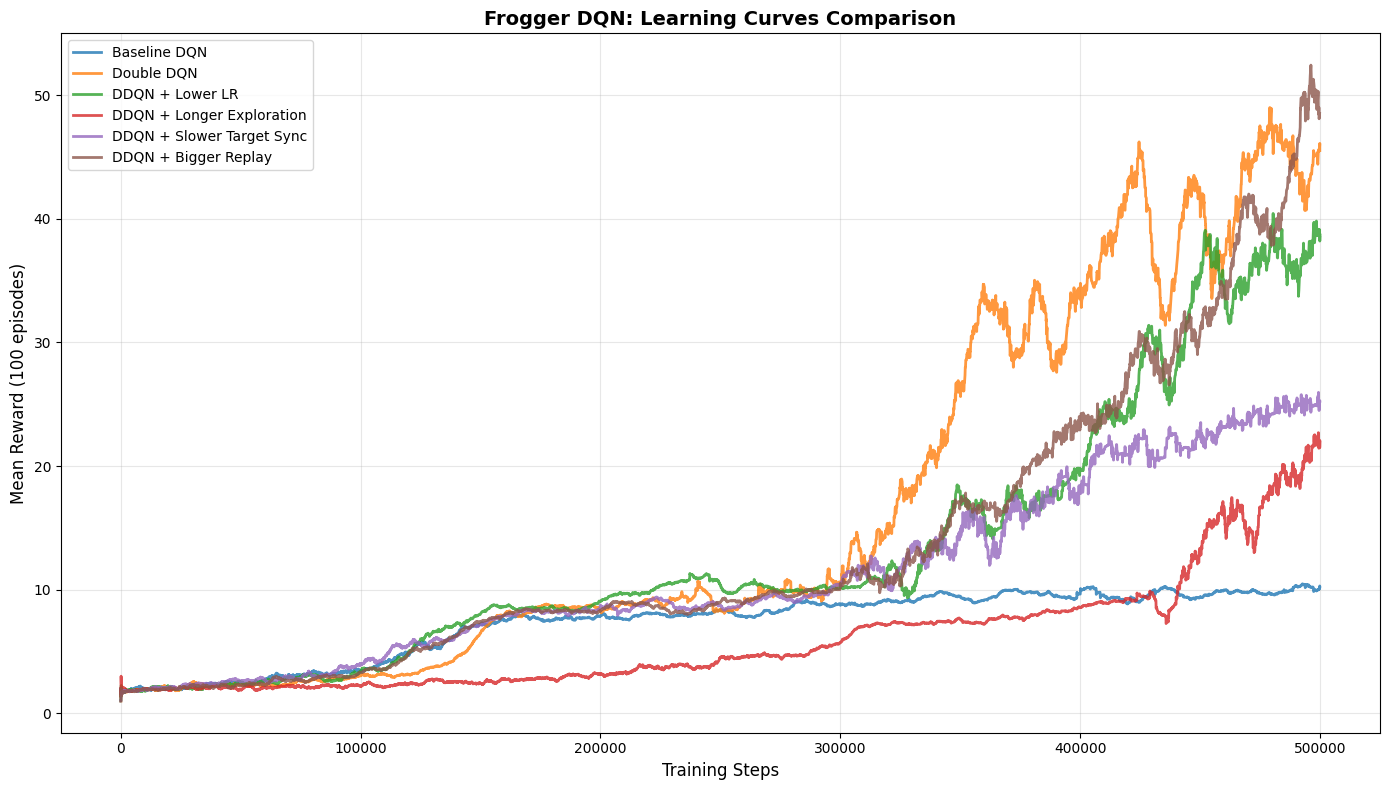

In [ ]:
# Plot learning curves
plt.figure(figsize=(14, 8))

for exp_name, metrics in all_results.items():
    config = EXPERIMENTS[exp_name]
    plt.plot(metrics['steps'], metrics['mean_reward_100'],
             label=config['name'], alpha=0.8, linewidth=2)

plt.xlabel('Training Steps', fontsize=12)
plt.ylabel('Mean Reward (100 episodes)', fontsize=12)
plt.title('Frogger DQN: Learning Curves Comparison', fontsize=14, fontweight='bold')
plt.legend(fontsize=10)
plt.grid(True, alpha=0.3)
plt.tight_layout()

# Save plot
plot_path = f"{PLOTS_DIR}/learning_curves_comparison.png"
plt.savefig(plot_path, dpi=300, bbox_inches='tight')
print(f"✓ Learning curves saved to: {plot_path}")
plt.show()

## Save summary to drive

In [ ]:
# Create summary table
summary = []
print("\n" + "="*100)
print("FINAL RESULTS SUMMARY")
print("="*100)
print(f"{'Experiment':<25} {'Final Mean':<12} {'Peak Reward':<12} {'Total Episodes':<15}")
print("-"*100)

for exp_name, metrics in all_results.items():
    config = EXPERIMENTS[exp_name]
    final_mean = metrics['mean_reward_100'][-1] if metrics['mean_reward_100'] else 0
    peak = max(metrics['episode_rewards']) if metrics['episode_rewards'] else 0
    total_eps = len(metrics['episode_rewards'])

    summary.append({
        'experiment': config['name'],
        'final_mean': final_mean,
        'peak': peak,
        'episodes': total_eps,
        'changes': config['changes']
    })

    print(f"{config['name']:<25} {final_mean:<12.1f} {peak:<12.1f} {total_eps:<15}")

print("="*100 + "\n")

# Save summary
with open(f"{BASE_DIR}/summary.json", 'w') as f:
    json.dump(summary, f, indent=2)

print(f"✓ Summary saved to: {BASE_DIR}/summary.json")


FINAL RESULTS SUMMARY
Experiment                Final Mean   Peak Reward  Total Episodes 
----------------------------------------------------------------------------------------------------
Baseline DQN              10.2         53.0         7059           
Double DQN                45.5         216.0        7671           
DDQN + Lower LR           38.7         176.0        7796           
DDQN + Longer Exploration 22.0         109.0        10002          
DDQN + Slower Target Sync 25.2         88.0         8855           
DDQN + Bigger Replay      48.5         157.0        7944           

✓ Summary saved to: /content/drive/MyDrive/CSCI166_Frogger_Project/summary.json


## Save Log Changes

In [ ]:
# Generate hyperparameter changes table for report
print("\n" + "="*100)
print("HYPERPARAMETER CHANGES LOG (for your report)")
print("="*100 + "\n")

changes_log = []
for exp_name, config in EXPERIMENTS.items():
    print(f"{config['name']}:")
    if config['changes']:
        for change in config['changes']:
            print(f"  - {change}")
            changes_log.append({'experiment': config['name'], 'change': change})
    else:
        print("  - None (baseline)")
        changes_log.append({'experiment': config['name'], 'change': 'None (baseline)'})
    print()

# Count total unique changes
unique_changes = set()
for config in EXPERIMENTS.values():
    unique_changes.update(config['changes'])

print(f"Total unique hyperparameter changes: {len(unique_changes)}")
print("\nChanges:")
for i, change in enumerate(sorted(unique_changes), 1):
    print(f"  {i}. {change}")

# Save changes log
with open(f"{BASE_DIR}/hyperparameter_changes.json", 'w') as f:
    json.dump(changes_log, f, indent=2)

print(f"\n✓ Changes log saved to: {BASE_DIR}/hyperparameter_changes.json")


HYPERPARAMETER CHANGES LOG (for your report)

Baseline DQN:
  - None (baseline)

Double DQN:
  - Algorithm: DQN → Double DQN

DDQN + Lower LR:
  - Algorithm: DQN → Double DQN
  - Learning Rate: 1e-4 → 5e-5

DDQN + Longer Exploration:
  - Algorithm: DQN → Double DQN
  - Epsilon Decay: 150k → 300k frames

DDQN + Slower Target Sync:
  - Algorithm: DQN → Double DQN
  - Target Sync: 1000 → 2500 frames

DDQN + Bigger Replay:
  - Algorithm: DQN → Double DQN
  - Replay Buffer: 10k → 30k

Total unique hyperparameter changes: 5

Changes:
  1. Algorithm: DQN → Double DQN
  2. Epsilon Decay: 150k → 300k frames
  3. Learning Rate: 1e-4 → 5e-5
  4. Replay Buffer: 10k → 30k
  5. Target Sync: 1000 → 2500 frames

✓ Changes log saved to: /content/drive/MyDrive/CSCI166_Frogger_Project/hyperparameter_changes.json


## Show some Sample Videos

In [ ]:
# Display first experiment's videos as example
first_exp = list(EXPERIMENTS.keys())[0]
video_dir = f"{VIDEOS_DIR}/{first_exp}"

print(f"\nSample videos from: {EXPERIMENTS[first_exp]['name']}\n")

# Find early and late videos
early_videos = [f for f in os.listdir(video_dir) if 'early' in f and f.endswith('.mp4')]
late_videos = [f for f in os.listdir(video_dir) if 'late' in f and f.endswith('.mp4')]

if early_videos:
    print("Early training (mostly random):")
    display(Video(os.path.join(video_dir, early_videos[0]), embed=True, width=400))

if late_videos:
    print("\nLate training (learned behavior):")
    display(Video(os.path.join(video_dir, late_videos[0]), embed=True, width=400))

print(f"\nAll videos saved to: {VIDEOS_DIR}")


Sample videos from: Baseline DQN

Early training (mostly random):



Late training (learned behavior):



All videos saved to: /content/drive/MyDrive/CSCI166_Frogger_Project/videos
